**EE 338**

**DSP RnD** (Group 25)

* Shounak Das (21D070068)

* Mrudul Nepalchand Jambhulkar (21D070044)

* Chinta Siva Madhav(21D070020)


In [1]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import inspect
import importlib


In [2]:
# Define the function to add gradient noise to an optimizer
def add_gradient_noise(BaseOptimizer, keras=None):
    if keras is None:
        if hasattr(BaseOptimizer, '__module__') and BaseOptimizer.__module__.startswith('keras'):
            keras = importlib.import_module('keras')
        else:
            keras = importlib.import_module('tensorflow.keras')

    K = keras.backend
    if not (
        inspect.isclass(BaseOptimizer) and
        issubclass(BaseOptimizer, keras.optimizers.Optimizer)
    ):
        raise ValueError(
            'add_gradient_noise() expects a valid Keras optimizer'
        )

    def _get_shape(x):
        if hasattr(x, 'dense_shape'):
            return x.dense_shape

        return K.shape(x)

    # Defining the NoisyOptimizer class, inheriting from the provided optimizer class
    class NoisyOptimizer(BaseOptimizer):
        def __init__(self, noise_eta=0.3, noise_gamma=0.55, **kwargs):
            super(NoisyOptimizer, self).__init__(**kwargs)
            with K.name_scope(self.__class__.__name__):
                self.noise_eta = K.variable(noise_eta, name='noise_eta')
                self.noise_gamma = K.variable(noise_gamma, name='noise_gamma')

        def get_gradients(self, loss, params):
            grads = super(NoisyOptimizer, self).get_gradients(loss, params)

            # Adding decayed Gaussian noise to gradients
            t = K.cast(self.iterations, K.dtype(grads[0]))
            variance = self.noise_eta / ((1 + t) ** self.noise_gamma)

            grads = [
                grad + K.random_normal(
                    _get_shape(grad),
                    mean=0.0,
                    stddev=K.sqrt(variance),
                    dtype=K.dtype(grads[0])
                )
                for grad in grads
            ]

            return grads

        def get_config(self):
            # Adding noise parameters to the optimizer's configuration
            config = {'noise_eta': float(K.get_value(self.noise_eta)),
                      'noise_gamma': float(K.get_value(self.noise_gamma))}
            base_config = super(NoisyOptimizer, self).get_config()
            return dict(list(base_config.items()) + list(config.items()))

    NoisyOptimizer.__name__ = 'Noisy{}'.format(BaseOptimizer.__name__)

    return NoisyOptimizer

In [3]:
# Loading CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


170498071/170498071 [==============================] - 11s 0us/step


In [4]:
# Defining the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),     # Convolutional layer with 32 filters of size 3x3, ReLU activation, and input shape of (32, 32, 3)
    MaxPooling2D((2, 2)),    # Max pooling layer with pool size 2x2
    Flatten(),    # Flatten layer to convert 2D feature maps into a 1D feature vector
    Dense(128, activation='relu'),    # Fully connected (Dense) layer with 128 neurons and ReLU activation
    Dense(10, activation='softmax')    # Output layer with 10 neurons (for 10 classes in CIFAR-10) and softmax activation
    ])
# Adding gradient noise to the optimizer
NoisyAdam = add_gradient_noise(Adam)

In [5]:
# Training the model
with tf.device('/GPU:0'):     # Using GPU for faster training
    model.compile(optimizer=NoisyAdam(), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/10
782/782 [==============================] - 36s 45ms/step - loss: 1.4750 - accuracy: 0.4747 - val_loss: 1.2838 - val_accuracy: 0.5497
Epoch 2/10
782/782 [==============================] - 34s 43ms/step - loss: 1.1841 - accuracy: 0.5850 - val_loss: 1.1572 - val_accuracy: 0.6011
Epoch 3/10
782/782 [==============================] - 33s 43ms/step - loss: 1.0619 - accuracy: 0.6296 - val_loss: 1.0827 - val_accuracy: 0.6247
Epoch 4/10
782/782 [==============================] - 34s 44ms/step - loss: 0.9593 - accuracy: 0.6672 - val_loss: 1.0660 - val_accuracy: 0.6296
Epoch 5/10
782/782 [==============================] - 33s 42ms/step - loss: 0.8847 - accuracy: 0.6908 - val_loss: 1.0572 - val_accuracy: 0.6383
Epoch 6/10
782/782 [==============================] - 34s 44ms/step - loss: 0.8160 - accuracy: 0.7158 - val_loss: 1.0291 - val_accuracy: 0.6502
Epoch 7/10
782/782 [==============================] - 34s 44ms/step - loss: 0.7492 - accuracy: 0.7408 - val_loss: 1.0288 - val_accuracy:

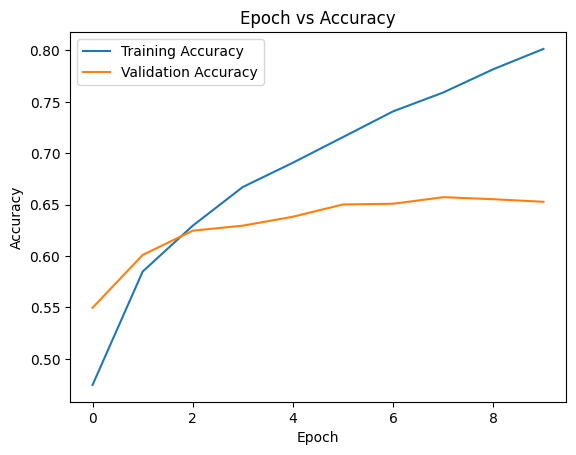

In [6]:
# Plotting epoch vs accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()